In [1]:
import sys
sys.path.append("/home/admin/blessed/HandWritten_Amharic_English_OCR")
from dataset.dataloader import MyOcrDataloader
import pandas as pd
import math
import random
import torch
import yaml
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from utils.utils import forward_pass_with_labels, update
from jiwer import wer, cer
from tqdm.auto import tqdm

# Load config
config_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), "config/main.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
DATASET_PATH = config["DATASET_PATH"]
# VAL_DATASET_PATH = config["VAL_DATASET_PATH"]
MODEL_ID = config["MODEL_ID"]

# Set up device, processor, and model
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained(MODEL_ID)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_ID).to(device)
model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Create data loaders
os.chdir("../dataset")
DATASET_PATH = "/home/admin/blessed/HandWritten_Amharic_English_OCR/dataset/labeled_english_train.csv"
train_data = MyOcrDataloader(DATASET_PATH, preprocessor=processor)
VAL_DATASET_PATH = "/home/admin/blessed/HandWritten_Amharic_English_OCR/dataset/labeled_english_test.csv"
val_data = MyOcrDataloader(VAL_DATASET_PATH, preprocessor=processor)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=config['BATCH_SIZE'],
    shuffle=True,
    collate_fn=train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=config['BATCH_SIZE'],
    shuffle=False,
    collate_fn=val_data.collate_fn
)

# Training and validation functions
def one_train_epoch(model, train_data_loader, scaler, optimizer):
    model.train()
    pbar = tqdm(range(len(train_data_loader)))
    train_loss = 0
    train_wers = 0.0
    train_cers = 0.0
    samples = 0
    for i, batch in enumerate(train_data_loader):
        loss, logits = update(model, optimizer,scaler, batch)
        preds = processor.batch_decode(logits.argmax(dim=2), skip_special_tokens=True)
        actuals = processor.batch_decode(batch[1], skip_special_tokens=True)

        train_loss += (1 / (i + 1)) * (loss - train_loss)
        for pred, actual in zip(preds, actuals):
            train_wers += wer(actual, pred)
            train_cers += cer(actual, pred)

        samples += len(preds)
        pbar.set_description(f"Train Loss: {train_loss:.4f} WER: {train_wers / samples:.4f} CER: {train_cers / samples:.4f}")
        pbar.update(1)
    pbar.close()
    return train_loss, train_wers / samples, train_cers / samples

def one_val_epoch(model, val_data_loader):
    model.eval()
    val_loss = 0
    val_wers = 0.0
    val_cers = 0.0
    samples = 0
    with torch.no_grad():
        pbar = tqdm(range(len(val_data_loader)))
        for i, batch in enumerate(val_data_loader):
            loss, logits = forward_pass_with_labels(model, batch)
            preds = processor.batch_decode(logits.argmax(dim=2), skip_special_tokens=True)
            actuals = processor.batch_decode(batch[1], skip_special_tokens=True)

            val_loss += (1 / (i + 1)) * (loss - val_loss)
            for pred, actual in zip(preds, actuals):
                val_wers += wer(actual, pred)
                val_cers += cer(actual, pred)

            samples += len(preds)
            pbar.set_description(f"Val Loss: {val_loss:.4f} WER: {val_wers / samples:.4f} CER: {val_cers / samples:.4f}")
            pbar.update(1)
        pbar.close()
    return val_loss, val_wers / samples, val_cers / samples

def train(model, tdataloader, vdataloader, optimizer, scaler,scheduler, epochs=3, log_dir="logs/a"):
    os.makedirs(log_dir, exist_ok=True)
    with open(f"{log_dir}/train.txt", "w") as tf, open(f"{log_dir}/val.txt", "w") as vf:
        tf.write("Epoch,Loss,WER,CER\n")
        vf.write("Epoch,Loss,WER,CER\n")

    best_val_score = float('inf')
    for epoch in range(1, 1 + epochs):
        train_loss, train_wers, train_cers = one_train_epoch(model, tdataloader, scaler, optimizer)
        val_loss, val_wers, val_cers = one_val_epoch(model, vdataloader)

        with open(f"{log_dir}/train.txt", "a") as tf, open(f"{log_dir}/val.txt", "a") as vf:
            tf.write(f"{epoch},{train_loss:.4f},{train_wers:.4f},{train_cers:.4f}\n")
            vf.write(f"{epoch},{val_loss:.4f},{val_wers:.4f},{val_cers:.4f}\n")

        if val_wers < best_val_score:
            best_val_score = val_wers
            torch.save(model.state_dict(), f"{log_dir}/best_model.pth")
            print(f"New best model saved with WER: {val_wers:.4f}")
        
        # Update the learning rate
        scheduler.step()
        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: LR = {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train WER: {train_wers:.4f}, Train CER: {train_cers:.4f}")
        print(f"Epoch {epoch}: Val Loss: {val_loss:.4f}, Val WER: {val_wers:.4f}, Val CER: {val_cers:.4f}")
# Initialize optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  
# Start training
train(model, train_loader, val_loader, optimizer, scaler, scheduler, epochs=20,  log_dir="logs/phi_teleqna")

2025-01-17 09:07:32.218515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 09:07:32.259291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 09:07:32.952151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2691744/2651094423.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 1.0725
Epoch 1: LR = 0.000100, Train Loss: 5.1261, Train WER: 1.1072, Train CER: 1.4980
Epoch 1: Val Loss: 2.6395, Val WER: 1.0725, Val CER: 0.9694


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 1.0072
Epoch 2: LR = 0.000100, Train Loss: 2.1812, Train WER: 1.0239, Train CER: 1.1226
Epoch 2: Val Loss: 2.3862, Val WER: 1.0072, Val CER: 1.0217


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 0.9928
Epoch 3: LR = 0.000050, Train Loss: 1.9641, Train WER: 0.9730, Train CER: 1.0162
Epoch 3: Val Loss: 2.4086, Val WER: 0.9928, Val CER: 0.8259


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 0.9638
Epoch 4: LR = 0.000050, Train Loss: 1.6447, Train WER: 0.9522, Train CER: 0.8411
Epoch 4: Val Loss: 1.9452, Val WER: 0.9638, Val CER: 0.7698


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 0.9348
Epoch 5: LR = 0.000050, Train Loss: 1.4677, Train WER: 0.9197, Train CER: 0.7667
Epoch 5: Val Loss: 1.9368, Val WER: 0.9348, Val CER: 0.6586


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6: LR = 0.000025, Train Loss: 1.2373, Train WER: 0.9081, Train CER: 0.7097
Epoch 6: Val Loss: 1.9578, Val WER: 0.9638, Val CER: 0.7786


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7: LR = 0.000025, Train Loss: 1.1016, Train WER: 0.9013, Train CER: 0.7118
Epoch 7: Val Loss: 1.9218, Val WER: 0.9928, Val CER: 0.6818


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8: LR = 0.000025, Train Loss: 0.9661, Train WER: 0.8897, Train CER: 0.6490
Epoch 8: Val Loss: 2.0517, Val WER: 1.0290, Val CER: 0.7820


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9: LR = 0.000013, Train Loss: 0.8687, Train WER: 0.8413, Train CER: 0.7178
Epoch 9: Val Loss: 2.0699, Val WER: 0.9565, Val CER: 0.6672


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10: LR = 0.000013, Train Loss: 0.7237, Train WER: 0.8045, Train CER: 0.5268
Epoch 10: Val Loss: 2.0486, Val WER: 0.9420, Val CER: 0.6264


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11: LR = 0.000013, Train Loss: 0.6775, Train WER: 0.7898, Train CER: 0.5164
Epoch 11: Val Loss: 2.0699, Val WER: 0.9638, Val CER: 0.6323


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

New best model saved with WER: 0.8986
Epoch 12: LR = 0.000006, Train Loss: 0.5997, Train WER: 0.7678, Train CER: 0.4729
Epoch 12: Val Loss: 2.1427, Val WER: 0.8986, Val CER: 0.5921


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13: LR = 0.000006, Train Loss: 0.5770, Train WER: 0.7377, Train CER: 0.4237
Epoch 13: Val Loss: 2.1434, Val WER: 0.9420, Val CER: 0.5989


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14: LR = 0.000006, Train Loss: 0.4960, Train WER: 0.7181, Train CER: 0.4034
Epoch 14: Val Loss: 2.1639, Val WER: 0.9493, Val CER: 0.6463


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15: LR = 0.000003, Train Loss: 0.4749, Train WER: 0.6991, Train CER: 0.3998
Epoch 15: Val Loss: 2.1556, Val WER: 0.9275, Val CER: 0.5904


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16: LR = 0.000003, Train Loss: 0.4304, Train WER: 0.6869, Train CER: 0.3746
Epoch 16: Val Loss: 2.2164, Val WER: 0.9275, Val CER: 0.6180


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17: LR = 0.000003, Train Loss: 0.4021, Train WER: 0.6893, Train CER: 0.3594
Epoch 17: Val Loss: 2.1999, Val WER: 0.9275, Val CER: 0.5829


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18: LR = 0.000002, Train Loss: 0.3906, Train WER: 0.6648, Train CER: 0.3603
Epoch 18: Val Loss: 2.2096, Val WER: 0.9203, Val CER: 0.6240


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19: LR = 0.000002, Train Loss: 0.3700, Train WER: 0.6624, Train CER: 0.3395
Epoch 19: Val Loss: 2.2119, Val WER: 0.9203, Val CER: 0.6259


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20: LR = 0.000002, Train Loss: 0.3574, Train WER: 0.6520, Train CER: 0.3155
Epoch 20: Val Loss: 2.2235, Val WER: 0.9203, Val CER: 0.6094


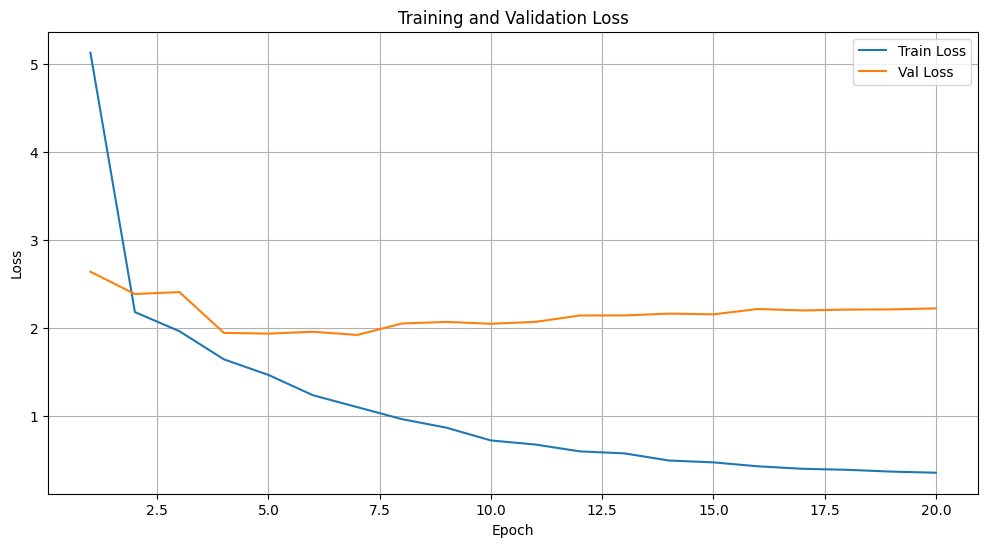

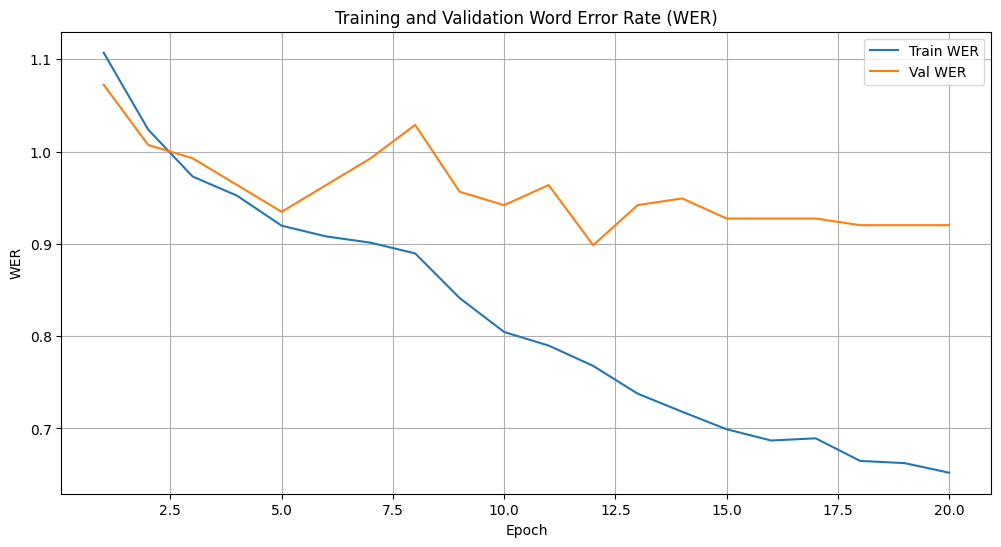

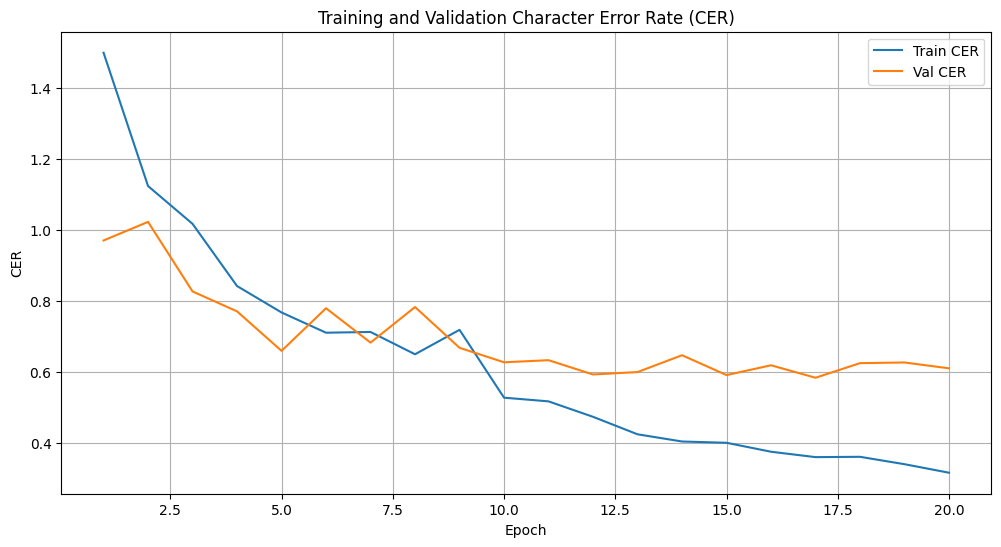

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the log directory
log_dir = "logs/phi_teleqna"

# Load training and validation metrics
train_metrics = pd.read_csv(f"{log_dir}/train.txt")
val_metrics = pd.read_csv(f"{log_dir}/val.txt")

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_metrics["Epoch"], train_metrics["Loss"], label="Train Loss")
plt.plot(val_metrics["Epoch"], val_metrics["Loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig(f"{log_dir}/loss_plot.png")  # Save plot
plt.show()

# Plot WER
plt.figure(figsize=(12, 6))
plt.plot(train_metrics["Epoch"], train_metrics["WER"], label="Train WER")
plt.plot(val_metrics["Epoch"], val_metrics["WER"], label="Val WER")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.title("Training and Validation Word Error Rate (WER)")
plt.legend()
plt.grid()
plt.savefig(f"{log_dir}/wer_plot.png")  # Save plot
plt.show()

# Plot CER
plt.figure(figsize=(12, 6))
plt.plot(train_metrics["Epoch"], train_metrics["CER"], label="Train CER")
plt.plot(val_metrics["Epoch"], val_metrics["CER"], label="Val CER")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Training and Validation Character Error Rate (CER)")
plt.legend()
plt.grid()
plt.savefig(f"{log_dir}/cer_plot.png")  # Save plot
plt.show()